In [2]:
# Imported Libraries
import pennylane as qml
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix
import random
import torch
from torchvision import datasets, transforms

In [3]:
from qiskit import IBMQ
from qiskit import Aer
from qiskit import *

In [4]:
import sys
sys.path.append("..") # Adds higher directory to python modules path
sys.path.append 

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e2_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

In [4]:
!pip install kaggle

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi
#import KaggleApi
api = KaggleApi()
api.authenticate()

https://www.kaggle.com/mlg-ulb/creditcardfraud/download
#downloading datasets for COVID-19 data
#api.dataset_download_files('imdevskp/corona-virus-report')
api.dataset_download_files('mlg-ulb/creditcardfraud')

SyntaxError: invalid syntax (2387988877.py, line 6)

# Credit Card Fraud - A Growing Issue

Credit card fraud is a growing issue with \\$28.5 billion lost globally due to credit card fraud in 2020 and is expected to exceed \\$49 billion by 2030 [1]). In 2020, around 1 out of 4 digital interactions were credit card fraud attempts (Cite Arkose Labs). Since there are so many non fraudulent transactions, it is challenging to detect the fraudulent transactions. In this notebook, we will be using a quantum auto-encoder to perform anomaly detection. 

We can use the quantum auto encoder to encode the 4 qubit state into a 3 qubit state and then use a decoder to decode the 3 qubit state back into 4 qubit state. The quantum auto encoder is trained on the normal dataset (or in this case the non fraudulent transactions) which means the quantum auto 
To tell if a datapoint is an anomaly, 

Import the dataset

In [5]:
df = pd.read_csv('creditcard.csv')

We are only going to print the first 5 rows because the dataset contains over 280,000 rows. Each row represents a transaction. Time shows the time passed between the current and first transactions and amount shows the dollar amount spent on the transaction. There are also 28 more features represented by V1, V2, ... , V28 which come from principal component analysis. Finally, there is the class, where a '0' represents no fraud committed and a '1' represents a fraudulent transaction

Let's now check the class distribution

In [6]:
print('No Frauds: ', df['Class'].value_counts()[0])
print('Frauds: ', df['Class'].value_counts()[1])

No Frauds:  284315
Frauds:  492


Credit card fraud is relatively rare, this creates a very imbalanced distribution. A very imbalanced distribution is not ideal as this can lead to overfitting and our model assuming no fraud most of the time. It is also challenging to find the true correlations between the features and class.

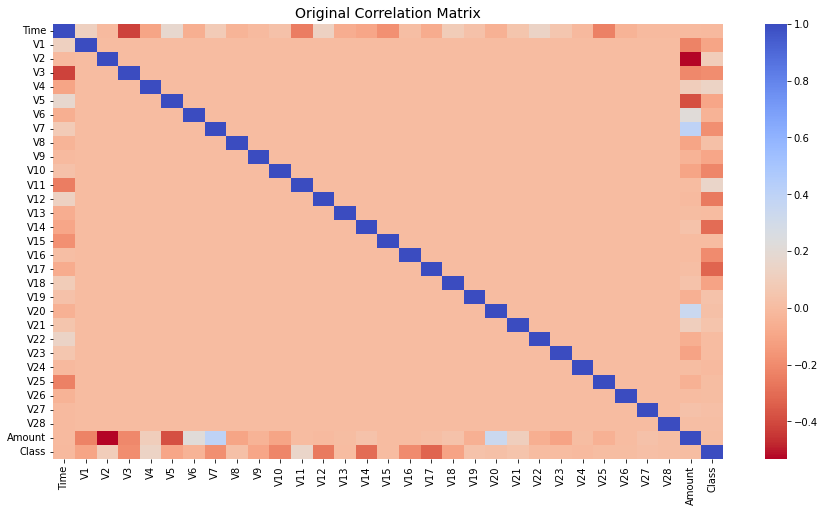

In [7]:
plot_correlation_matrix(df, "Original Correlation Matrix")

As you can see, nothing can really be inferred from this correlation matrix since the data is so imbalanced. We are going to create a sub sample dataset with equal amounts of non fraudulent data and fraudulent data. We are also going to scale the 'Time' and 'Amount' values for better processing. 

In [8]:
#from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import RobustScaler

# Scaling amount and time for the subsample
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True) # Drop the original time and amount values

# Add scaled amount and times to the data frame
scaled_amount = df['scaled_amount'] 
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Create the balanced subsample of 49
df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

# Display the first 5 rows t ose
sub_sample_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
53016,-0.027947,-0.457230,1.405868,-0.601871,0.040949,-0.495781,-1.027817,-1.139317,-0.392392,-0.187445,...,-0.059937,0.133630,0.325643,-0.148828,0.397281,0.719644,-0.059995,-0.023802,0.001439,0
42549,0.925452,-0.511578,-5.314173,4.145944,-8.532522,8.344392,-5.718008,-3.043536,-10.989185,3.404129,...,1.150017,2.331466,0.862996,-0.614453,0.523648,-0.712593,0.324638,2.245091,0.497321,1
276070,-0.269825,0.965601,-0.051945,1.056283,-0.471742,-0.565640,1.107964,-0.790051,1.011454,-0.198296,...,0.056846,-0.327291,-0.761251,0.172249,0.498639,-0.358447,0.106874,0.107111,0.072178,0
91671,3.747363,-0.248053,-0.639191,-0.085595,1.265452,1.401166,-0.260542,1.009795,1.301999,-0.135258,...,0.861307,0.340331,0.760170,0.353377,-0.778893,-0.070681,-0.033355,-0.061962,-0.062687,1
226814,9.020471,0.706258,-2.405207,2.943823,-7.616654,3.533374,-5.417494,-0.112632,-1.329372,1.709417,...,-0.338707,0.652683,0.414132,0.023869,-0.260616,0.405316,0.029107,0.519807,-0.469537,1


We can now plot the correlation matrix of our new sub sample to get a better idea of the true correlations between features and 'Class' 

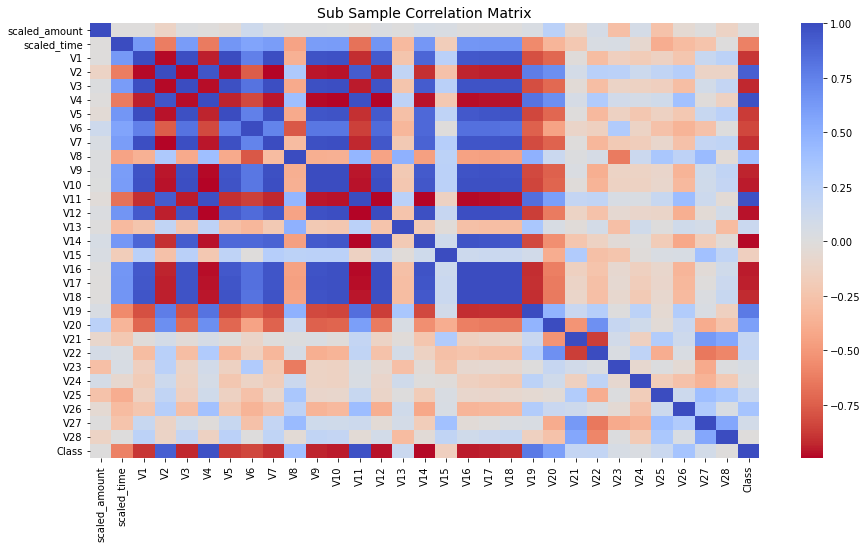

In [9]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

The correlations are now much more noticeable. Now, we can find the features with the strongest correlation to class. Half are the strongest positive correlations, half are the strongest negative correlations. 

In [10]:
def find_strongest_correlations(dataframe, latent_qubits):
    
    num_features = latent_qubits**2
    
    class_correlations = dataframe.loc['Class', :]
    class_correlations = class_correlations.drop(index = 'Class')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(num_features/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations

feature_list, correlations = find_strongest_correlations(sub_sample_corr, 4)

print(find_strongest_correlations(sub_sample_corr, 4))

(['V4', 'V14', 'V11', 'V12', 'V2', 'V10', 'V19', 'V16', 'V20', 'V3', 'V21', 'V17', 'V28', 'V9', 'V27', 'V7'], [0.7049280336690459, -0.7491777234950696, 0.6839459727426278, -0.677290478542406, 0.48594631996592036, -0.6228064388962743, 0.24025481223101428, -0.5901179580594654, 0.16528809523020951, -0.561764117252581, 0.12903443052145347, -0.5605289480943042, 0.08345266375453653, -0.5538916275260506, 0.08181031705095593, -0.4772773115289583])


We now have 16 features that are the most correlated with 'Class'. In this use case, we will be using 4 qubits to represent the data which means we will need 2$^{4}$ = 16 features to encode into the 4 qubits though amplitude encoding. Later, we will use the quantum autoencoder to encode the 4 qubits into 3 qubits and then use a decoder to decode those 3 qubits back to 4 qubits. 

In [11]:
# Dataframe of all non fraudulent transactions
branch = df
non_fraud = branch[branch["Class"]!="1"]

# All examples of non fraudulent data with 16 features
non_fraud = non_fraud[feature_list]
non_fraud.head()

input_data = non_fraud.to_numpy()

# Training 


In [12]:
shots = 1000 #The amount of shots used for each epoch of training
nr_trash= 1   # Number of qubits 'thrown away'
nr_latent= 3  # Number of qubits left after the encoder is used
nr_ent = 0

epochs = 500   # Number of iterations of training to perform to find the final encoder parameters
learning_rate = .005 # Learning rate for the optimizer, dictates how fast the optimizer trains
batch_size = 2
num_samples = 250  # Number of training samples used for each epoch

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

# Organizes and specifies our qubits for the device
spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
'''
from qiskit import IBMQ
#set up the device 
token = ("bdfb136f41f48dcab8cfc1bad4d78a53ef82fc659bd63e6decfb01526e7897904f5726e4cb3014f34fbb40ab745b733b9fe6219a6d9c28a2ee45cf36da171abb")
#IBMQ.enable_account(token = token, hub = "ibm-q-community", group="qhack-hackathon", project="16-qubit")
IBMQ.save_account(token)

IBMQ.load_account()
'''
#dev = qml.device("default.qubit", wires=spec.num_qubits)
#dev = qml.device('qiskit.aer', wires=spec.num_qubits, backend = 'qasm_simulator')
#dev = qml.device('qiskit.ibmq', wires=spec.num_qubits, backend = 'ibmq_guadalupe', ibmqx_token = "6e4f256437ce3d5584d80d4225e0a36d6130e4de2c02729f534738aa2af1339597611d259697cea67e328ad92c5e0904cbff534000873532d8d4ede831471985")



#print("Qubits:", spec.qubits)

NameError: name 'qubits' is not defined

In [18]:
@qml.qnode(dev_qiskit)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder 

    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]


In [19]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [20]:
# Define cost function
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [21]:
# Define fidelity function
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [22]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [23]:

training_data = [ torch.tensor([input_data[i]]) for i in range(num_samples)]
test_data = [ torch.tensor([input_data[i]]) for i in range(num_samples,num_samples+num_samples)]

X_training = training_data
X_tes = test_data

print(training_data[0])

tensor([[-0.8773,  0.5715,  2.0238,  0.7888, -1.1801, -1.0931, -0.8933, -1.4779,
         -0.1247,  0.7038,  0.3755,  0.9897,  0.0279,  1.8524,  0.1258, -1.0145]],
       dtype=torch.float64)


In [24]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)
print(encoder_params)

[[0.72018426 0.30569105 0.90495009 0.16021417 0.19719008 0.04813054
  0.43504184 0.34291596 0.18660038 0.78938944 0.14492228 0.0991565
  0.92356054 0.86956302 0.87714132 0.45731088 0.35224722 0.08065993
  0.39733112 0.14327083 0.32896114 0.28107414 0.89973877 0.90294404
  0.257959   0.97893129 0.1437341  0.88391522 0.06040788 0.82206722
  0.43475041 0.48060816 0.95600381 0.68062473 0.6465662  0.44065466
  0.84296845 0.80959582 0.09809009 0.48530809 0.33245541 0.48800818
  0.03999866 0.39054903 0.09123385 0.92456295 0.28152668 0.65910197
  0.5403846  0.61132974 0.52378562 0.90174968 0.3686259  0.56652058
  0.85335049 0.50251205 0.30624943 0.32868616 0.57940058 0.4702492
  0.58927974 0.33662438 0.35338481 0.26134444 0.56863648 0.38665056
  0.51430622 0.11991423 0.66091214 0.3586576  0.88470366 0.54765449
  0.39677877 0.05649007 0.19225498 0.54847306 0.93839963 0.93370181
  0.93027395 0.49602302 0.70047351 0.16193628 0.86663692 0.33572692
  0.53722295 0.02959347 0.31365244 0.34736321 0.81

In [19]:
'''
print(encoder_params)

#reinit_state = [0 for i in range(2 ** 4)]
#reinit_state[0] = 1.0
print(reinit_state)
print(len(spec.aux_qubits))
#print(training_circuit_example(encoder_params, encoder_params, reinit_state = reinit_state))
'''

'\nprint(encoder_params)\n\n#reinit_state = [0 for i in range(2 ** 4)]\n#reinit_state[0] = 1.0\nprint(reinit_state)\nprint(len(spec.aux_qubits))\n#print(training_circuit_example(encoder_params, encoder_params, reinit_state = reinit_state))\n'

In [25]:
# Create a tensor dataset with only fraud data and most correlated features 
# for finding the fidelity of the quantum autoencoder on fraud transactions

fraud = fraud_df[feature_list]
np_fraud = fraud.to_numpy()
fraud_data = [ torch.tensor([np_fraud[i]]) for i in range(len(fraud.to_numpy()))] 

fraud.head()


,V4,V14,V11,V12,V2,V10,V19,V16,V20,V3,V21,V17,V28,V9,V27,V7
249607,3.728439,-5.757216,2.528943,-3.308722,-7.449015,-4.029129,0.136722,-1.547552,2.932758,-4.696287,1.176575,-1.909017,-1.229992,-0.646203,0.704915,-5.831452
234574,5.304534,-12.457999,3.536145,-7.959628,4.362801,-6.285424,-1.802332,-1.424131,0.531574,-6.023534,0.397954,-3.243686,0.531932,-4.037021,0.847220,-1.530817
50211,3.880960,-7.052311,3.525726,-6.489112,3.663395,-5.726817,1.147878,-6.773977,-0.346456,-5.297446,2.698175,-8.588070,-0.073360,-2.457034,-0.183463,-5.715262
75511,2.796987,-5.419590,2.338323,-2.820042,1.956099,-3.245109,0.930239,-4.180758,0.270459,-0.851198,1.208054,-4.285071,0.075309,-1.184468,0.562239,-1.340739
17453,6.505862,-4.829552,3.947840,-5.487911,16.434525,-7.800598,0.608930,-5.121162,1.724779,-30.558697,1.812954,-11.118190,0.364530,-3.591491,1.255649,-20.081391


In [47]:
encoder_params = torch.tensor([[-0.45793534, -0.60180382,  1.36706854, -0.39273726,  0.78967496,
         -0.11834691,  1.21601293,  0.7257659 ,  0.16775198,  0.87110514,
          0.5825973 ,  1.35786832,  1.6198694 , -0.21858262,  1.41542989,
          1.2968311 ,  1.8630585 ,  0.50511886,  0.75524677,  0.82482716,
          1.02949018, -0.023521  ,  0.55110408,  0.15877528,  0.62316124,
          0.37113699,  0.4557925 ,  0.62940097,  0.61549768,  0.95122916,
          0.22349399,  0.86457997,  0.81546047,  1.47984623,  1.72818011,
         -0.30175269,  0.67999145, -0.22226086,  0.94370564,  1.48028116,
          0.72720142,  0.20210445,  0.14995309,  0.19133051, -0.35101019,
          0.40932117, -0.09846242,  0.65960454,  0.78151562,  1.17058629,
          0.23858532,  0.71485483,  0.31327769,  1.63693523,  0.95525645,
          0.58935465,  0.76165831,  0.62729872,  0.55561916,  0.19378356,
          0.41408805,  1.01374824,  0.37282255, -0.06769513,  0.45583351,
         -0.05101048,  0.83344398,  1.58156091,  1.46059524,  0.9371276 ,
          0.96522386,  0.27626285,  0.19818911,  0.11227637,  0.38220371,
          0.64166103,  0.92703234,  0.3736458 ,  0.21161801,  0.62412085,
          0.3278856 , -0.18893975,  0.86769553,  0.78573112,  0.50142613,
          0.96622037,  0.40300401,  0.55802604,  0.12912973,  0.14822851]], requires_grad=True)





loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

fraud_fid=[]


batches = iterate_batches(X=training_data, batch_size=batch_size)
#for xbatch in batches:
    #encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
   
        
loss_training = cost(encoder_params, X_training )
fidel = fidelity(encoder_params, X_training )
        
loss_hist.append(loss_training)
fid_hist.append(fidel)
print("Loss:{} | Fidelity:{}".format(loss_training, fidel))

loss_test = cost(encoder_params, X_tes )
fidel = fidelity(encoder_params, X_tes )
loss_hist_test.append(loss_test)
fid_hist_test.append(fidel)
print("Test-Loss:{} | Test-Fidelity:{}".format(loss_test, fidel))
        
f_fidel = fidelity(encoder_params, fraud_data )
fraud_fid.append(f_fidel)
print("Fraud Fidelity:{}".format(f_fidel))

Loss:1.1646492553529781 | Fidelity:0.866216
Test-Loss:1.1751370974959725 | Test-Fidelity:0.8550239999999999
Fraud Fidelity:0.6496487804878046


In [28]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

fraud_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        f_fidel = fidelity(encoder_params, fraud_data )
        fraud_fid.append(f_fidel)
        print("Fraud Fidelity:{}".format(f_fidel))

/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


TypeError: Can't find vector space for value 1.4058367913051657 of type <class 'torch.Tensor'>. Valid types are dict_keys([<class 'autograd.core.SparseObject'>, <class 'list'>, <class 'tuple'>, <class 'dict'>, <class 'numpy.ndarray'>, <class 'float'>, <class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>, <class 'complex'>, <class 'numpy.complex64'>, <class 'numpy.complex128'>, <class 'pennylane.numpy.tensor.tensor'>])

IndexError: list index out of range

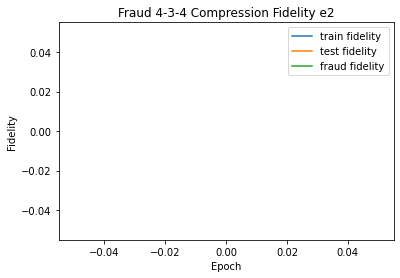

In [66]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fidelity")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fidelity")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fraud_fid),label="fraud fidelity")

plt.legend()
plt.title("Fraud 4-3-4 Compression Fidelity e2 Qiskit",)
plt.xlabel("Epoch")
plt.ylabel("Fidelity")
plt.savefig("Fraud 4-3-4 Compression Fidelity e2 Qiskit")

print("fidelity:",fid_hist[-1])

loss: 1.102373216675469


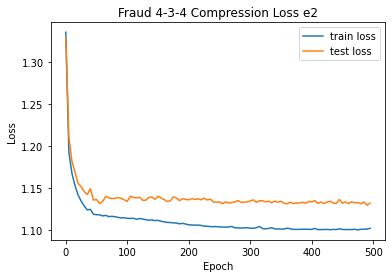

In [97]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Fraud 4-3-4 Compression Loss e2 - Qiskit",)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Fraud 4-3-4 Compression Loss e2 - Qiskit")

print("loss:",loss_hist[-1])

In [96]:
name = "fraud_434_training_e2-Braket"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent, "nr_ent":nr_ent  }
Training_param = { "num_samples" == num_samples,
                    "batch_size" == batch_size,
                    #"nr_layers"== nr_layers,
                    "epochs" == epochs,
                    "learning_rate" == learning_rate, 
                    "beta1" == beta1,
                    "beta2 "== beta2,
                     "optimizer"=="Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

17547

In [101]:
experiment_parameters={"autoencoder":"e2","params":encoder_params}
f=open("Params_Fraud_encoder_e2-CorrelatedFeautures-Braket.txt","w")
f.write(str(experiment_parameters))

1386

In [14]:
token = 'bdfb136f41f48dcab8cfc1bad4d78a53ef82fc659bd63e6decfb01526e7897904f5726e4cb3014f34fbb40ab745b733b9fe6219a6d9c28a2ee45cf36da171abb'
IBMQ.save_account(token,overwrite=True)  #save your creds
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q-community', group='qhack-hackathon', project='16-qubit')
dev_qiskit = qml.device('qiskit.ibmq', wires=spec.num_qubits, backend='ibmq_guadalupe',provider=provider)



ibmqfactory.load_account:WARNING:2022-02-25 13:01:02,918: Credentials are already in use. The existing account in the session will be replaced.


In [26]:
branch = df 
non_fraud_df = branch.loc[branch["Class"]!=1][:250]


non_fraud = non_fraud_df[feature_list]
np_non_fraud = non_fraud.to_numpy()
non_fraud_data = [ torch.tensor([np_non_fraud[i]]) for i in range(len(non_fraud.to_numpy()))]

non_fraud_flist=[]
for b in non_fraud_data:
    f=fidelity(encoder_params, [b])
    non_fraud_flist.append(f.item())
    
print(min(non_fraud_flist))
print(max(non_fraud_flist))

/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/seanmcilvane/anaconda3/envs/ENV_NAME/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


0.416015625
0.748046875


In [27]:

branch = df 
fraud_df = branch.loc[branch["Class"]!=0][:250]


fraud = fraud_df[feature_list]
np_fraud = fraud.to_numpy()
fraud_data = [ torch.tensor([np_fraud[i]]) for i in range(len(fraud.to_numpy()))]



fraud_flist=[]
for b in fraud_data:
    f=fidelity(encoder_params, [b])
    fraud_flist.append(f.item())
    
print(min(fraud_flist))
print(max(fraud_flist))

0.525390625
0.7529296875


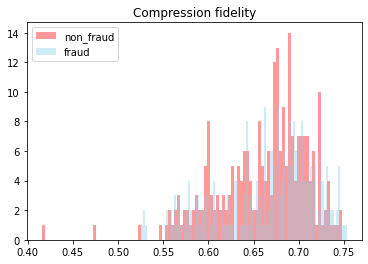

In [28]:

plt.hist(non_fraud_flist, bins =100 ,label="non_fraud",color = "red",alpha=0.4)
plt.hist(fraud_flist, bins = 100 ,label="fraud", color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.savefig("Compression_fidelity-Qiskit")
plt.show()

In [29]:
split=0.75


print("split:",split)
b_e=[]
for i in fraud_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("non fraud classification accuracy:",ab_ac)
m_e=[]
for i in non_fraud_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("fraud accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.75
non fraud classification accuracy: 0.992
fraud accuracy: 0.0
total accuracy: 0.496
